In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading
%matplotlib inline

In [2]:
df_label = pd.read_csv('Synthetic_AL_5.csv')
df_unlabeled = pd.read_csv('agaricus-lepiota_labeled_columns.csv')

In [3]:
# Missing values on the unlabeled dataset have '?' instead of NaN
np.sum(df_unlabeled.iloc[:,:] == '?')

Edible?                        0
Cap-shape                      0
Cap-surface                    0
Cap-color                      0
Bruises?                       0
Odor                           0
Gill-attacment                 0
Gill-spacing                   0
Gill-size                      0
Gill-color                     0
Stalk-shape                    0
Stalk-root                  2480
Stalk-surface-above-ring       0
Stalk-surface-below-ring       0
Stalk-color-above-ring         0
Stalk-color-below-ring         0
Veil-Type                      0
Veil-Color                     0
Ring-number                    0
Ring-Type                      0
Spore-print-color              0
Population                     0
Habitat                        0
dtype: int64

In [4]:
# Replace '?' with np.nan
indx = df_unlabeled.iloc[:,:] == '?'
df_unlabeled.iloc[indx] = np.nan

np.sum(pd.isnull(df_unlabeled))

Edible?                        0
Cap-shape                      0
Cap-surface                    0
Cap-color                      0
Bruises?                       0
Odor                           0
Gill-attacment                 0
Gill-spacing                   0
Gill-size                      0
Gill-color                     0
Stalk-shape                    0
Stalk-root                  2480
Stalk-surface-above-ring       0
Stalk-surface-below-ring       0
Stalk-color-above-ring         0
Stalk-color-below-ring         0
Veil-Type                      0
Veil-Color                     0
Ring-number                    0
Ring-Type                      0
Spore-print-color              0
Population                     0
Habitat                        0
dtype: int64

In [5]:
# Find how many missing values we have on the labeled dataset
np.sum(pd.isnull(df_label))

Edible?                      0
Cap-shape                    0
Cap-surface                  5
Cap-color                    0
Bruises?                    25
Odor                        25
Gill-attacment               0
Gill-spacing                 0
Gill-size                    0
Gill-color                   0
Stalk-shape                  0
Stalk-root                  95
Stalk-surface-above-ring     0
Stalk-surface-below-ring     0
Stalk-color-above-ring       0
Stalk-color-below-ring       0
Veil-Type                    0
Veil-Color                   0
Ring-number                  0
Ring-Type                    0
Spore-print-color            0
Population                  10
Habitat                      0
Species                      0
dtype: int64

We see that there is a few missing values on our labeled dataset. We also see that a lot of the samples were missing the stalk-root feature. The absence of this feature might be helpful in identifying those samples which do have the feature.

Because of this, we will fill the empty data with a value that represents that the data is missing ('?')

In [6]:
df_label = df_label.fillna('?')
df_unlabeled = df_unlabeled.fillna('?')

For the Label Spreading algorithm we have to make one big dataset with our labeled and unlabeled datapoints. We will encode the known labels and then  assign the label of -1 to all unlabeled samples

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode the labels for our labeled dataset

le = LabelEncoder()
enc_label = le.fit_transform(df_label['Species'])

df_label['Species'] = enc_label

# Assign a dummy label to our unlabeled dataset

df_unlabeled['Species'] = -1;

# Combine our datasets

df = pd.concat([df_label, df_unlabeled],ignore_index=True)

df = df.sample(frac = 1)

In [8]:
df.head()

,Edible?,Cap-shape,Cap-surface,Cap-color,Bruises?,Odor,Gill-attacment,Gill-spacing,Gill-size,Gill-color,...,Stalk-color-above-ring,Stalk-color-below-ring,Veil-Type,Veil-Color,Ring-number,Ring-Type,Spore-print-color,Population,Habitat,Species
4313,p,x,f,g,f,c,f,w,n,n,...,w,w,p,w,o,p,k,v,d,-1
6396,p,x,s,e,f,y,f,c,n,b,...,p,w,p,w,o,e,w,v,l,-1
6264,p,f,s,n,f,s,f,c,n,b,...,p,p,p,w,o,e,w,v,p,-1
1347,e,f,f,g,f,n,f,w,b,k,...,w,w,p,w,o,e,k,a,g,-1
7569,p,f,y,n,f,f,f,c,n,b,...,w,p,p,w,o,e,w,v,l,-1


The next part is an important step. We known that edibility of all samples, which is good for someone that's out and about eating mushrooms in the wild. But if we are to predict the species of a mushroom just from it's physical characteristics we cannot possibly know the edibility of a mushroom without knowing it's species. Therefore we chose to drop this column before proceeding any further (no training of any kind has been done so far.

In [9]:
df = df.drop('Edible?',axis = 1)

In [10]:
# Split the labels from the input dataset

X = df.drop('Species',axis = 1)
y = df['Species']

In [11]:
# Before finally applying our algorithm we need to encode our inputs
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X = enc.fit_transform(X)

In [12]:
# We deal with outliers 
from sklearn.ensemble import IsolationForest

outlier_det = IsolationForest(contamination = 0.01)

outlier_det.fit(X)

X_clean = outlier_det.predict(X)

X_with_outlier = X.toarray()

X = X_with_outlier[list(X_clean == 1),:]
y = y[list(X_clean == 1)]






In [13]:
# We run a 40 PCA as this was the value at the elbow of the PCA analysis
from sklearn.decomposition import PCA

pca_16 = PCA(n_components=40)

X = pca_16.fit_transform(X)


In [14]:
# We will run the out-of-the-box label spreading algorithm
from sklearn.semi_supervised import LabelSpreading

label_prop_model = LabelSpreading(kernel = 'rbf', gamma = 23, alpha = 0.2)

label_prop_model.fit(X,y)

y_pred = label_prop_model.predict(X)

y_color = y_pred

y_pred = le.inverse_transform(y_pred)

In [15]:
# We now run 3PCA on our dataset for visualization purposes

pca = PCA(n_components=3)

X_3pca = pca.fit_transform(X)

For reference, we will plot the unlabeled dataset and the original labeled points

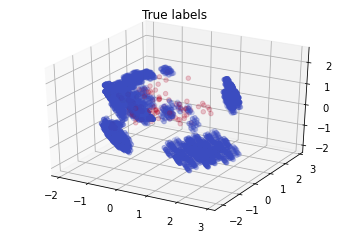

In [16]:
# Plot the original datasets together
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

s = (y != -1).astype(int)

#indx = np.where(s==1)[0]

#alphas = s
#alphas[:] = 0.5
#alphas[indx] = 1

# Plot
ax.scatter(xs = X_3pca[:,0] , ys = X_3pca[:,1] , zs = X_3pca[:,2] , alpha = 0.2, c = s, cmap = 'coolwarm')

plt.title('True labels')
plt.show()

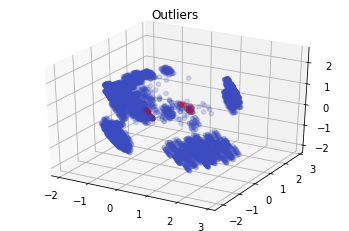

In [17]:
# We will also plot the location of the outliers

X_with_outliers = df.drop('Species',axis = 1)

X_with_outliers = enc.transform(X_with_outliers)

X_3pca_outlier = pca.fit_transform(X_with_outliers.toarray())

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

s = (X_clean == -1).astype(int)

#indx = np.where(s==1)[0]

#alphas = s
#alphas[:] = 0.5
#alphas[indx] = 1

# Plot
ax.scatter(xs = X_3pca_outlier[:,0] , ys = X_3pca_outlier[:,1] , zs = X_3pca_outlier[:,2] , alpha = 0.2, c = s, cmap = 'coolwarm')

plt.title('Outliers')
plt.show()




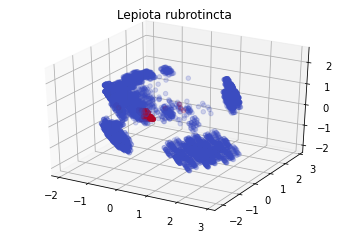

In [18]:
# Plot the 3 PC with the predicted labels

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Which species do we want to see

sp = 22

s = (y_color==sp).astype(int)

# Plot
ax.scatter(xs = X_3pca[:,0] , ys = X_3pca[:,1] , zs = X_3pca[:,2] , alpha = 0.2, c = s, cmap = 'coolwarm')
#Axes3D.scatter(xs = X_3pca[:,0] , ys = X_3pca[:,1] , zs = X_3pca[:,2] ,zdir ='z', c=y_pred)
plt.title(le.inverse_transform([sp])[0])
plt.show()

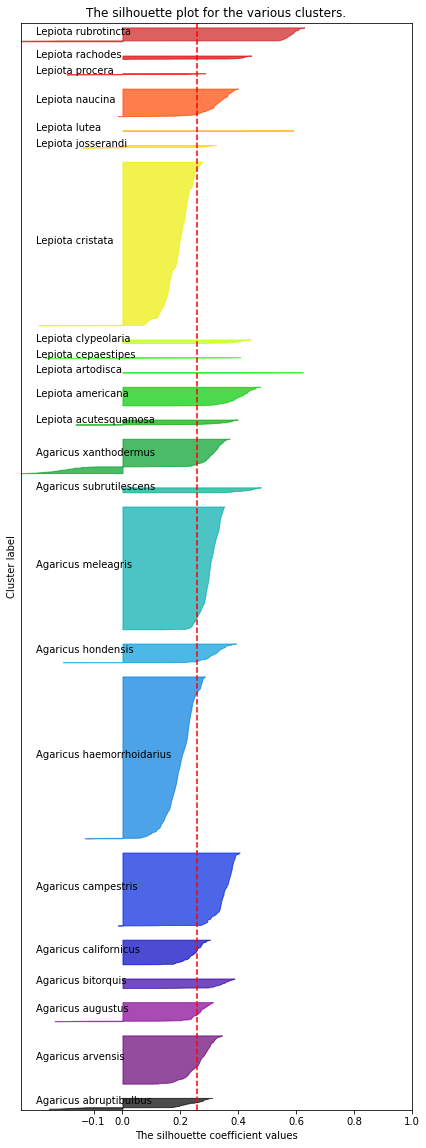

In [19]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

silhouette_avg = silhouette_score(X, y_color)

sample_silhouette_values = silhouette_samples(X, y_color)

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(7, 20)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.35, 0.8])
ax1.set_ylim([0, len(X) + (np.size(list(set(y_color))) + 1) * 140])

y_lower = 10
for i in list(set(y_color)):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_color == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / np.size(list(set(y_color))))
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.3, y_lower + 0.5 * size_cluster_i, le.inverse_transform([i])[0])

    # Compute the new y_lower for next plot
    y_lower = y_upper + 150 # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Now that we have the infrastructure of our model, and a metric to evaluate it (mean silhouette coefficient), we can optimize the model for the highest performance. High performance in our case Would mean that all sets of mushroom labels are more or less evenly distributed and all are part of a well defined cluster.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#X = df.drop('Species',axis = 1)
#X = enc.fit_transform(X)
y = df['Species']

silh_score = make_scorer(silhouette_score)

#parameters = {'kernel':('knn','rbf'), 'gamma': np.linspace(0,1,11), 'n_neighbors': np.arange(23), 'n_jobs': [-1]}
parameters = {'kernel':['rbf'], 'gamma': [10,20], 'alpha': [0.2,0.5,0.7], 'n_jobs': [-1]}

clf = GridSearchCV(label_prop_model,parameters)#,scoring = silh_score)

clf.fit(X,y_color)
#(np.array(y)).reshape(-1, 1)

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:290: ConvergenceWarning: max_it

GridSearchCV(estimator=LabelSpreading(gamma=23),
             param_grid={'alpha': [0.2, 0.5, 0.7], 'gamma': [10, 20],
                         'kernel': ['rbf'], 'n_jobs': [-1]})

In [22]:
clf.cv_results_

{'mean_fit_time': array([2.20432358, 2.39876709, 3.12399063, 3.62581577, 4.40895596,
        4.92960839]),
 'std_fit_time': array([0.10813541, 0.05453129, 0.05536581, 0.03654311, 0.10126124,
        0.04110012]),
 'mean_score_time': array([0.22655745, 0.22177768, 0.2068903 , 0.21858363, 0.19322805,
        0.2044415 ]),
 'std_score_time': array([0.01640965, 0.00868436, 0.01316741, 0.00955565, 0.00581289,
        0.00700204]),
 'param_alpha': masked_array(data=[0.2, 0.2, 0.5, 0.5, 0.7, 0.7],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[10, 20, 10, 20, 10, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_jobs': mas

In [23]:
clf.best_score_

0.9960765529387722

In [24]:
clf.best_params_

{'alpha': 0.7, 'gamma': 10, 'kernel': 'rbf', 'n_jobs': -1}